# Face Generation
In this project, we use generative adversarial networks (GANs) to generate new images of faces.
### Get the Data
Using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
# data_dir = '~/data'
data_dir = '/home/thojo/work/ud/deep-learning/face_generation/data'
import helper
import pickle as pkl
# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'

In [2]:
# """
# DON'T MODIFY ANYTHING IN THIS CELL
# """


# helper.download_extract('mnist', data_dir)
# helper.download_extract('celeba', data_dir)

## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

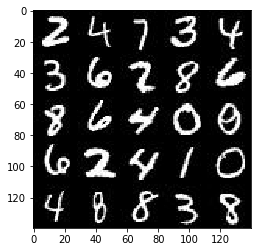

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

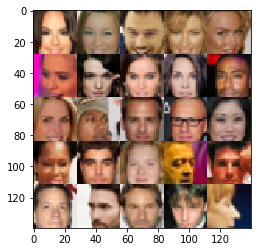

In [4]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [5]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

/home/thojo/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


TensorFlow Version: 1.7.0
Default GPU Device: /device:GPU:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [6]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim ):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    inputs_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='input_real')
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    learning_rate = tf.placeholder(tf.float32, name='learning_rate')
    
    return inputs_real, inputs_z, learning_rate

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [7]:
def discriminator(images, reuse=False, alpha = 0.2):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # done: implement function
    with tf.variable_scope('discriminator', reuse=reuse):
            # Input layer is 28x28x1 for MNIST and celebA
            
            x1 = tf.layers.conv2d(images, 64, 5, strides = 2, padding = 'same') 
            # no batch_normalization in the first layer
            lrelu1 = tf.maximum( alpha*x1, x1)
            # now 14x14x64

            x2 = tf.layers.conv2d(lrelu1, 128, 5, strides = 2, padding = 'same')
            bn2 = tf.layers.batch_normalization( x2, training = True )
            lrelu2 = tf.maximum( alpha*bn2, bn2)
            # now 7x7x128

            x3 = tf.layers.conv2d(lrelu1, 256, 5, strides = 2, padding = 'same')
            bn3 = tf.layers.batch_normalization( x3, training = True )
            lrelu3 = tf.maximum( alpha*bn3, bn3)
            # now 4x4x256

            flat = tf.reshape( lrelu3,(-1,4*4*256) ) 
            logits = tf.layers.dense( flat, 1 )
            out = tf.sigmoid( logits )

            return out, logits

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [8]:
def generator(z, out_channel_dim, is_train=True, alpha = 0.2):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    with tf.variable_scope("generator", reuse=not is_train):   
        # Fully connected
        x1 = tf.layers.dense(z, 2*2*256)
        # Reshape first layer as 2x2x256
        x1 = tf.reshape(x1, (-1, 2, 2, 256))
        x1 = tf.layers.batch_normalization(x1, training=True)
        x1 = tf.maximum( alpha*x1, x1) #leaky relu

        # Second layer as (7x7x128)
        x2 = tf.layers.conv2d_transpose(x1, 128, 5, strides=2, padding='VALID')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum( alpha*x2, x2) #leaky relu
        
        # Third layer as (14x14x64)
        x3 = tf.layers.conv2d_transpose(x2, 64, 5, strides=2, padding='SAME')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum( alpha*x3, x3) #leaky relu

        # Ouput layer as (28x28x out_channel_dim)
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 5, strides=2, padding='SAME')
        out = tf.tanh(logits)

    return out

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [9]:
def model_loss(input_real, input_z, out_channel_dim ):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    
    g_model = generator(input_z, out_channel_dim )
    d_model_real, d_logits_real = discriminator( input_real, reuse = False )
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True )

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [10]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize, controlling dependencies approporiately
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [11]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])
    
    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [15]:
def train(epoch_count, batch_size, z_dim, learning_rate_scalar, beta1, get_batches, data_shape, data_image_mode, print_every=100, show_every=200):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # Build Model
    input_real, input_z, learning_rate = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim )
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3])
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1 )
 
    saver = tf.train.Saver()
    samples, losses = [], []
    steps = 0
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            # Train Model
            for batch_images in get_batches(batch_size):
                batch_images = batch_images * 2 #rescaling to match the (-1,1) range of the tanh outputs from the generator
                steps += 1
                # Sample random noise for G 
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                # Run optimizers
                _ = sess.run( d_opt, feed_dict={ input_real: batch_images, input_z: batch_z, learning_rate: learning_rate_scalar})
                _ = sess.run( g_opt, feed_dict={ input_z: batch_z, input_real: batch_images, learning_rate: learning_rate_scalar})

                if steps % print_every == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({ input_z: batch_z, input_real: batch_images, learning_rate: learning_rate_scalar })
                    train_loss_g = g_loss.eval({ input_z: batch_z, learning_rate: learning_rate_scalar})

                    print("Epoch {}/{}...".format(epoch_i+1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    # Save losses to view after training
                    losses.append((train_loss_d, train_loss_g))

                if steps % show_every == 0:
                    show_generator_output(sess, 25, input_z, data_shape[3], data_image_mode)

        saver.save(sess, './checkpoints/generator.ckpt')

    with open('samples.pkl', 'wb') as f:
        pkl.dump(samples, f)
    
    return losses, samples                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/20... Discriminator Loss: 1.1557... Generator Loss: 0.8121
Epoch 1/20... Discriminator Loss: 1.1455... Generator Loss: 0.9036


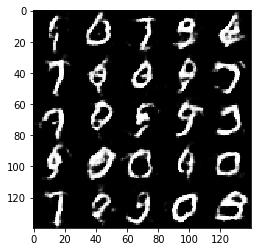

Epoch 1/20... Discriminator Loss: 1.1945... Generator Loss: 0.8250
Epoch 2/20... Discriminator Loss: 1.0551... Generator Loss: 1.1210


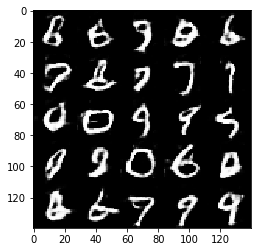

Epoch 2/20... Discriminator Loss: 1.0618... Generator Loss: 0.9189
Epoch 2/20... Discriminator Loss: 0.9859... Generator Loss: 0.9590


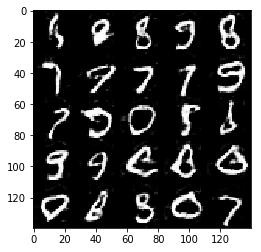

Epoch 2/20... Discriminator Loss: 0.9570... Generator Loss: 0.9490
Epoch 3/20... Discriminator Loss: 1.0150... Generator Loss: 0.9725


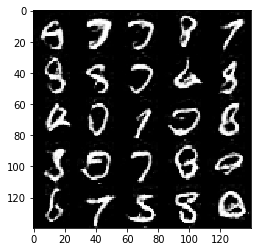

Epoch 3/20... Discriminator Loss: 0.9879... Generator Loss: 0.8482
Epoch 3/20... Discriminator Loss: 1.0432... Generator Loss: 1.0806


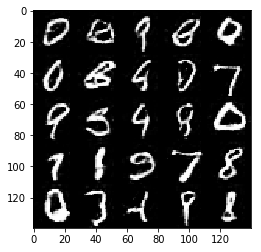

Epoch 3/20... Discriminator Loss: 1.0997... Generator Loss: 0.9144
Epoch 4/20... Discriminator Loss: 1.0542... Generator Loss: 0.9763


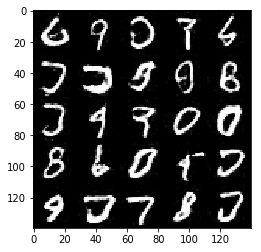

Epoch 4/20... Discriminator Loss: 1.0565... Generator Loss: 0.9276
Epoch 4/20... Discriminator Loss: 1.3058... Generator Loss: 0.5666


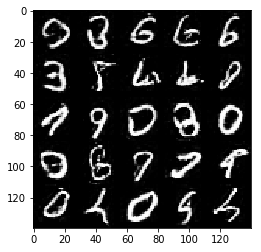

Epoch 4/20... Discriminator Loss: 1.0440... Generator Loss: 0.9457
Epoch 5/20... Discriminator Loss: 1.0235... Generator Loss: 0.9884


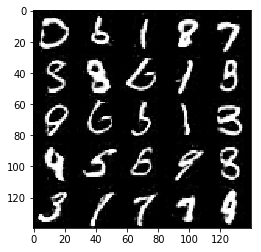

Epoch 5/20... Discriminator Loss: 1.5713... Generator Loss: 1.1181
Epoch 5/20... Discriminator Loss: 0.9845... Generator Loss: 0.9972


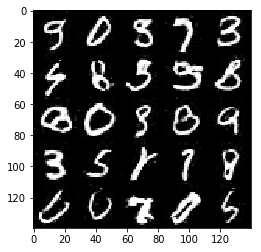

Epoch 6/20... Discriminator Loss: 1.1246... Generator Loss: 0.9769
Epoch 6/20... Discriminator Loss: 1.0336... Generator Loss: 1.0039


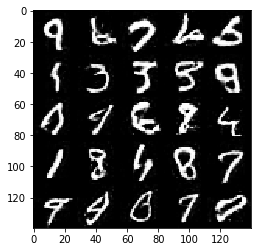

Epoch 6/20... Discriminator Loss: 1.0783... Generator Loss: 0.9223
Epoch 6/20... Discriminator Loss: 1.0471... Generator Loss: 0.9083


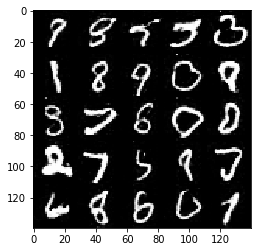

Epoch 7/20... Discriminator Loss: 1.0115... Generator Loss: 0.9831
Epoch 7/20... Discriminator Loss: 1.0298... Generator Loss: 0.7927


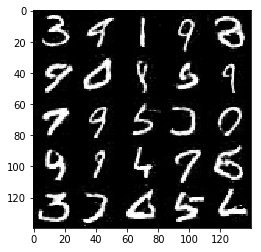

Epoch 7/20... Discriminator Loss: 0.9641... Generator Loss: 0.9241
Epoch 7/20... Discriminator Loss: 0.9914... Generator Loss: 0.9822


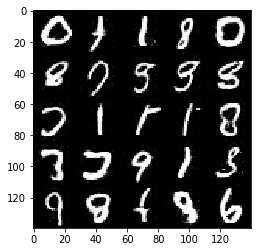

Epoch 8/20... Discriminator Loss: 1.1083... Generator Loss: 0.9458
Epoch 8/20... Discriminator Loss: 1.1402... Generator Loss: 1.0496


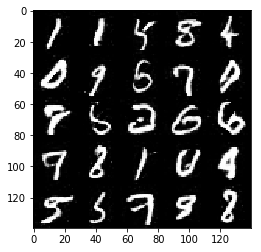

Epoch 8/20... Discriminator Loss: 0.9734... Generator Loss: 0.9899
Epoch 8/20... Discriminator Loss: 1.1307... Generator Loss: 0.9307


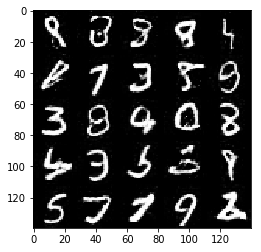

Epoch 9/20... Discriminator Loss: 0.9441... Generator Loss: 0.8998
Epoch 9/20... Discriminator Loss: 0.9931... Generator Loss: 1.1078


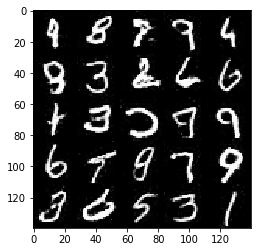

Epoch 9/20... Discriminator Loss: 1.0966... Generator Loss: 1.0363
Epoch 10/20... Discriminator Loss: 1.0615... Generator Loss: 1.0101


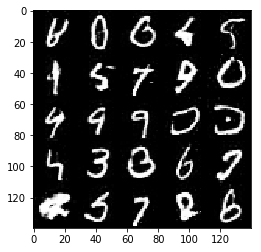

Epoch 10/20... Discriminator Loss: 1.0173... Generator Loss: 0.9121
Epoch 10/20... Discriminator Loss: 0.9450... Generator Loss: 0.9401


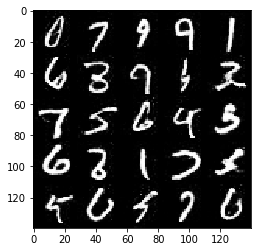

Epoch 10/20... Discriminator Loss: 0.9226... Generator Loss: 1.0520
Epoch 11/20... Discriminator Loss: 0.8695... Generator Loss: 0.9878


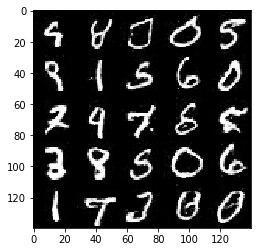

Epoch 11/20... Discriminator Loss: 0.8710... Generator Loss: 0.9906
Epoch 11/20... Discriminator Loss: 0.9606... Generator Loss: 0.9486


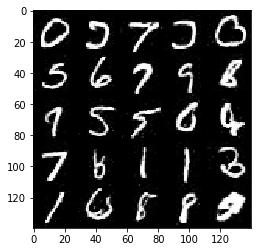

Epoch 11/20... Discriminator Loss: 0.8522... Generator Loss: 1.1191
Epoch 12/20... Discriminator Loss: 0.9671... Generator Loss: 1.1013


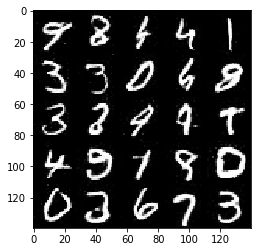

Epoch 12/20... Discriminator Loss: 0.9521... Generator Loss: 1.0280
Epoch 12/20... Discriminator Loss: 0.9081... Generator Loss: 1.0071


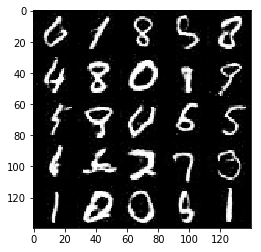

Epoch 12/20... Discriminator Loss: 0.9464... Generator Loss: 0.9639
Epoch 13/20... Discriminator Loss: 0.8057... Generator Loss: 1.2521


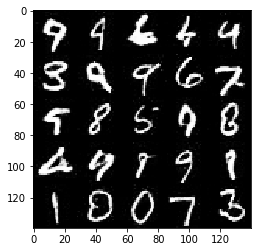

Epoch 13/20... Discriminator Loss: 0.8346... Generator Loss: 1.2796
Epoch 13/20... Discriminator Loss: 0.8375... Generator Loss: 1.1750


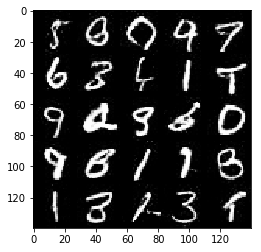

Epoch 14/20... Discriminator Loss: 0.9200... Generator Loss: 1.0277
Epoch 14/20... Discriminator Loss: 0.8774... Generator Loss: 1.1107


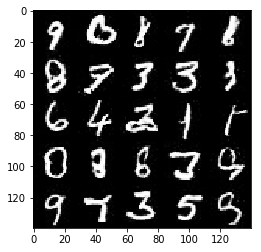

Epoch 14/20... Discriminator Loss: 0.8195... Generator Loss: 1.1252
Epoch 14/20... Discriminator Loss: 0.8834... Generator Loss: 0.9908


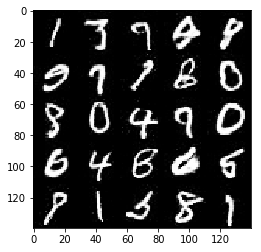

Epoch 15/20... Discriminator Loss: 0.7366... Generator Loss: 1.2786
Epoch 15/20... Discriminator Loss: 0.8063... Generator Loss: 1.1627


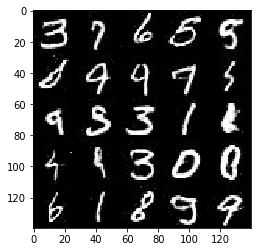

Epoch 15/20... Discriminator Loss: 0.7819... Generator Loss: 1.2876
Epoch 15/20... Discriminator Loss: 0.7552... Generator Loss: 1.3477


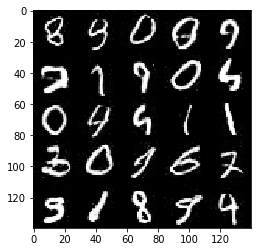

Epoch 16/20... Discriminator Loss: 1.0862... Generator Loss: 1.0613
Epoch 16/20... Discriminator Loss: 0.7776... Generator Loss: 1.1126


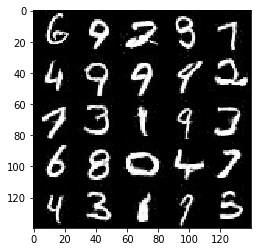

Epoch 16/20... Discriminator Loss: 0.7368... Generator Loss: 1.3332
Epoch 16/20... Discriminator Loss: 0.8301... Generator Loss: 1.0731


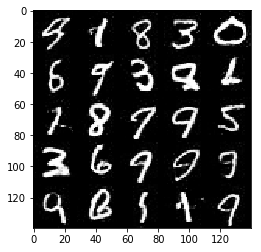

Epoch 17/20... Discriminator Loss: 0.7314... Generator Loss: 1.3244
Epoch 17/20... Discriminator Loss: 0.8803... Generator Loss: 1.3052


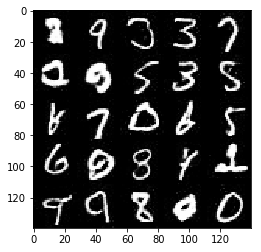

Epoch 17/20... Discriminator Loss: 0.8272... Generator Loss: 1.3303
Epoch 18/20... Discriminator Loss: 0.9865... Generator Loss: 0.9717


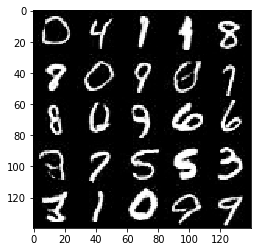

Epoch 18/20... Discriminator Loss: 0.7988... Generator Loss: 1.1987
Epoch 18/20... Discriminator Loss: 0.7316... Generator Loss: 1.2575


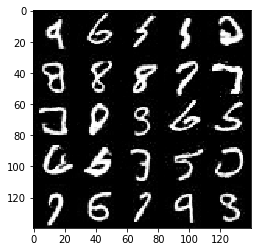

Epoch 18/20... Discriminator Loss: 0.8133... Generator Loss: 1.1683
Epoch 19/20... Discriminator Loss: 0.8422... Generator Loss: 1.4450


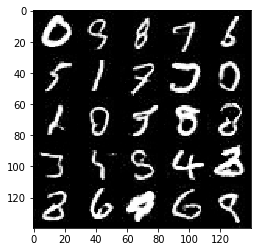

Epoch 19/20... Discriminator Loss: 0.6917... Generator Loss: 1.2391
Epoch 19/20... Discriminator Loss: 0.6627... Generator Loss: 1.4184


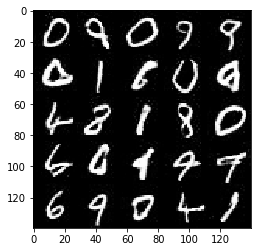

Epoch 19/20... Discriminator Loss: 0.8242... Generator Loss: 1.4055
Epoch 20/20... Discriminator Loss: 0.7933... Generator Loss: 1.2576


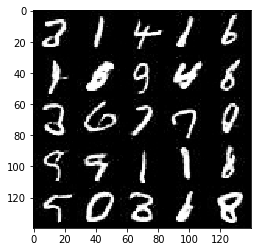

Epoch 20/20... Discriminator Loss: 0.8033... Generator Loss: 1.1866
Epoch 20/20... Discriminator Loss: 0.6642... Generator Loss: 1.5934


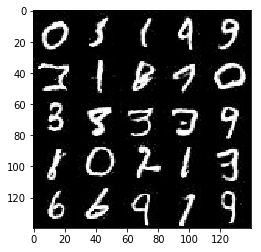

Epoch 20/20... Discriminator Loss: 0.6546... Generator Loss: 1.4466


In [13]:
batch_size = 32 #needs to be a factor of 4096
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5

print_every = 100
show_every = 200
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 20

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, 
          mnist_dataset.image_mode, print_every, show_every)

I notice here (and also while running on AWS) that the generator loss oscillates a little at first, but then settles around 3.0-4.0.

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/10... Discriminator Loss: 0.7983... Generator Loss: 1.1348
Epoch 1/10... Discriminator Loss: 0.5223... Generator Loss: 1.4270
Epoch 1/10... Discriminator Loss: 0.5938... Generator Loss: 1.4954
Epoch 1/10... Discriminator Loss: 0.6207... Generator Loss: 1.4408
Epoch 1/10... Discriminator Loss: 0.5794... Generator Loss: 1.4245


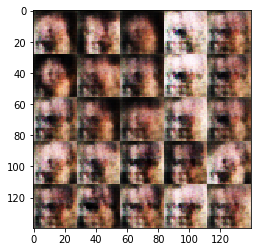

Epoch 1/10... Discriminator Loss: 0.6383... Generator Loss: 1.3317
Epoch 1/10... Discriminator Loss: 0.7560... Generator Loss: 1.2350
Epoch 1/10... Discriminator Loss: 0.8579... Generator Loss: 1.1539
Epoch 1/10... Discriminator Loss: 0.8778... Generator Loss: 1.1541
Epoch 1/10... Discriminator Loss: 0.8969... Generator Loss: 1.2059


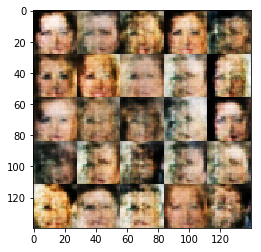

Epoch 1/10... Discriminator Loss: 0.8245... Generator Loss: 1.2231
Epoch 1/10... Discriminator Loss: 0.8612... Generator Loss: 1.1670
Epoch 1/10... Discriminator Loss: 0.8962... Generator Loss: 1.1720
Epoch 1/10... Discriminator Loss: 0.9806... Generator Loss: 0.9345
Epoch 1/10... Discriminator Loss: 0.7468... Generator Loss: 1.2277


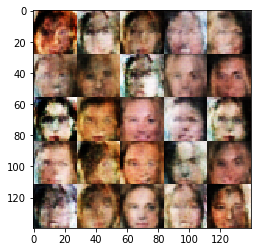

Epoch 1/10... Discriminator Loss: 0.8703... Generator Loss: 1.1352
Epoch 1/10... Discriminator Loss: 0.8041... Generator Loss: 1.2320
Epoch 1/10... Discriminator Loss: 1.2591... Generator Loss: 1.2949
Epoch 1/10... Discriminator Loss: 1.0134... Generator Loss: 0.9488
Epoch 1/10... Discriminator Loss: 0.9618... Generator Loss: 1.0424


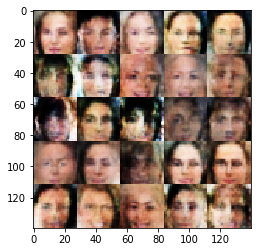

Epoch 1/10... Discriminator Loss: 0.8427... Generator Loss: 1.1962
Epoch 1/10... Discriminator Loss: 0.9692... Generator Loss: 1.0688
Epoch 1/10... Discriminator Loss: 0.9592... Generator Loss: 1.0604
Epoch 1/10... Discriminator Loss: 0.8052... Generator Loss: 1.1239
Epoch 1/10... Discriminator Loss: 0.8814... Generator Loss: 1.4055


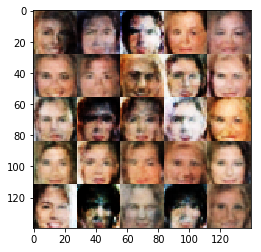

Epoch 1/10... Discriminator Loss: 0.9098... Generator Loss: 1.1817
Epoch 1/10... Discriminator Loss: 0.8380... Generator Loss: 1.0673
Epoch 1/10... Discriminator Loss: 0.8722... Generator Loss: 1.1311
Epoch 1/10... Discriminator Loss: 0.8504... Generator Loss: 1.4723
Epoch 1/10... Discriminator Loss: 0.9765... Generator Loss: 1.1483


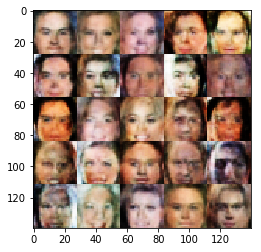

Epoch 1/10... Discriminator Loss: 1.0670... Generator Loss: 1.2085
Epoch 2/10... Discriminator Loss: 0.7897... Generator Loss: 1.2415
Epoch 2/10... Discriminator Loss: 0.7143... Generator Loss: 1.3691
Epoch 2/10... Discriminator Loss: 0.9100... Generator Loss: 1.0025
Epoch 2/10... Discriminator Loss: 0.8169... Generator Loss: 1.2958


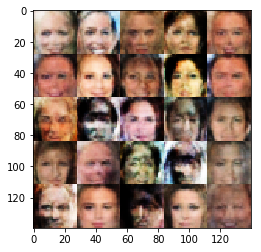

Epoch 2/10... Discriminator Loss: 0.9093... Generator Loss: 0.9723
Epoch 2/10... Discriminator Loss: 0.8914... Generator Loss: 1.0584
Epoch 2/10... Discriminator Loss: 0.8368... Generator Loss: 1.0735
Epoch 2/10... Discriminator Loss: 0.8689... Generator Loss: 1.2244
Epoch 2/10... Discriminator Loss: 0.7775... Generator Loss: 1.1374


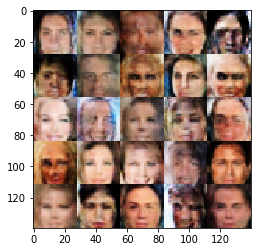

Epoch 2/10... Discriminator Loss: 0.9035... Generator Loss: 1.1866
Epoch 2/10... Discriminator Loss: 0.8315... Generator Loss: 1.7233
Epoch 2/10... Discriminator Loss: 0.8513... Generator Loss: 1.1047
Epoch 2/10... Discriminator Loss: 0.9366... Generator Loss: 1.0244
Epoch 2/10... Discriminator Loss: 0.8692... Generator Loss: 1.0370


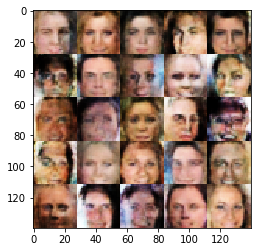

Epoch 2/10... Discriminator Loss: 0.9103... Generator Loss: 1.1247
Epoch 2/10... Discriminator Loss: 0.6310... Generator Loss: 1.6537
Epoch 2/10... Discriminator Loss: 0.8276... Generator Loss: 1.0963
Epoch 2/10... Discriminator Loss: 1.0368... Generator Loss: 1.0455
Epoch 2/10... Discriminator Loss: 0.8720... Generator Loss: 1.0359


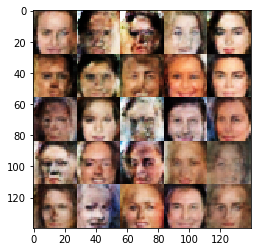

Epoch 2/10... Discriminator Loss: 0.7800... Generator Loss: 1.5600
Epoch 2/10... Discriminator Loss: 0.8831... Generator Loss: 1.0399
Epoch 2/10... Discriminator Loss: 0.9424... Generator Loss: 1.1538
Epoch 2/10... Discriminator Loss: 0.8410... Generator Loss: 1.2068
Epoch 2/10... Discriminator Loss: 1.7976... Generator Loss: 1.7309


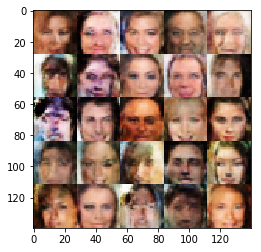

Epoch 2/10... Discriminator Loss: 0.8818... Generator Loss: 1.1448
Epoch 2/10... Discriminator Loss: 0.8426... Generator Loss: 1.1796
Epoch 2/10... Discriminator Loss: 0.8830... Generator Loss: 1.0816
Epoch 2/10... Discriminator Loss: 0.8958... Generator Loss: 1.1237
Epoch 2/10... Discriminator Loss: 0.8654... Generator Loss: 1.2608


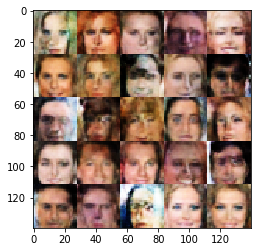

Epoch 2/10... Discriminator Loss: 1.2216... Generator Loss: 1.6202
Epoch 2/10... Discriminator Loss: 0.9204... Generator Loss: 1.0940
Epoch 2/10... Discriminator Loss: 0.8226... Generator Loss: 1.1037
Epoch 3/10... Discriminator Loss: 0.8865... Generator Loss: 1.0523
Epoch 3/10... Discriminator Loss: 0.8470... Generator Loss: 1.1842


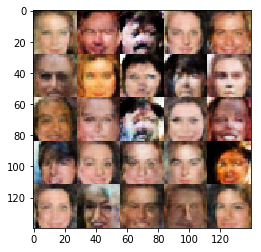

Epoch 3/10... Discriminator Loss: 0.9339... Generator Loss: 1.1534
Epoch 3/10... Discriminator Loss: 0.7812... Generator Loss: 1.1579
Epoch 3/10... Discriminator Loss: 0.9682... Generator Loss: 1.1520
Epoch 3/10... Discriminator Loss: 0.9787... Generator Loss: 1.1513
Epoch 3/10... Discriminator Loss: 0.8808... Generator Loss: 1.1431


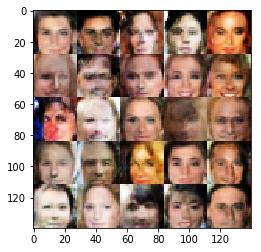

Epoch 3/10... Discriminator Loss: 1.0184... Generator Loss: 1.2053
Epoch 3/10... Discriminator Loss: 1.4944... Generator Loss: 1.0477
Epoch 3/10... Discriminator Loss: 0.9942... Generator Loss: 1.2094
Epoch 3/10... Discriminator Loss: 0.8049... Generator Loss: 1.5777
Epoch 3/10... Discriminator Loss: 0.8155... Generator Loss: 1.2799


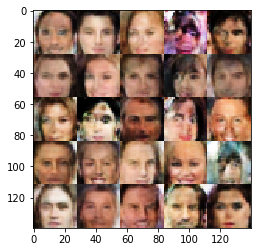

Epoch 3/10... Discriminator Loss: 0.7958... Generator Loss: 1.1334
Epoch 3/10... Discriminator Loss: 0.9807... Generator Loss: 1.0500
Epoch 3/10... Discriminator Loss: 0.9592... Generator Loss: 0.9179
Epoch 3/10... Discriminator Loss: 0.9012... Generator Loss: 1.2523
Epoch 3/10... Discriminator Loss: 0.8074... Generator Loss: 1.0978


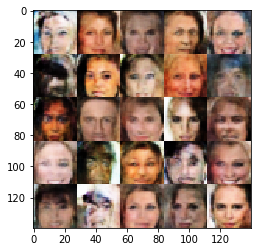

Epoch 3/10... Discriminator Loss: 0.8607... Generator Loss: 1.1989
Epoch 3/10... Discriminator Loss: 0.8760... Generator Loss: 1.1715
Epoch 3/10... Discriminator Loss: 0.6955... Generator Loss: 1.5521
Epoch 3/10... Discriminator Loss: 0.8874... Generator Loss: 1.0757
Epoch 3/10... Discriminator Loss: 0.8477... Generator Loss: 1.1104


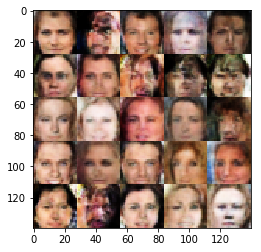

Epoch 3/10... Discriminator Loss: 0.9284... Generator Loss: 1.2656
Epoch 3/10... Discriminator Loss: 0.8936... Generator Loss: 1.3651
Epoch 3/10... Discriminator Loss: 0.8879... Generator Loss: 1.1091
Epoch 3/10... Discriminator Loss: 0.8965... Generator Loss: 1.1418
Epoch 3/10... Discriminator Loss: 1.0187... Generator Loss: 0.8667


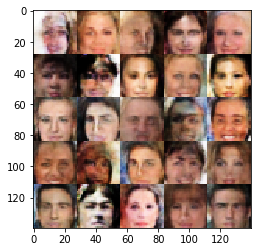

Epoch 3/10... Discriminator Loss: 0.9087... Generator Loss: 1.1656
Epoch 3/10... Discriminator Loss: 0.8434... Generator Loss: 1.3172
Epoch 3/10... Discriminator Loss: 0.9745... Generator Loss: 1.0843
Epoch 3/10... Discriminator Loss: 0.9363... Generator Loss: 1.1283
Epoch 4/10... Discriminator Loss: 0.9175... Generator Loss: 1.0489


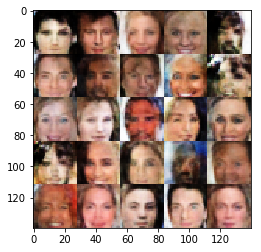

Epoch 4/10... Discriminator Loss: 1.0036... Generator Loss: 0.9746
Epoch 4/10... Discriminator Loss: 0.9963... Generator Loss: 0.9815
Epoch 4/10... Discriminator Loss: 0.7996... Generator Loss: 1.2797
Epoch 4/10... Discriminator Loss: 0.9455... Generator Loss: 1.1289
Epoch 4/10... Discriminator Loss: 0.9296... Generator Loss: 1.0793


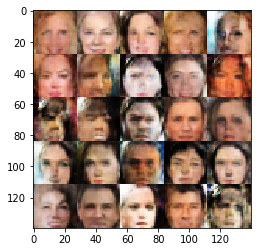

Epoch 4/10... Discriminator Loss: 0.9886... Generator Loss: 1.1494
Epoch 4/10... Discriminator Loss: 0.9071... Generator Loss: 1.1415
Epoch 4/10... Discriminator Loss: 0.9271... Generator Loss: 1.1350
Epoch 4/10... Discriminator Loss: 0.8171... Generator Loss: 1.1284
Epoch 4/10... Discriminator Loss: 0.8870... Generator Loss: 1.2763


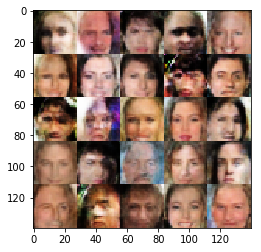

Epoch 4/10... Discriminator Loss: 0.9550... Generator Loss: 1.1406
Epoch 4/10... Discriminator Loss: 0.7930... Generator Loss: 1.3828
Epoch 4/10... Discriminator Loss: 0.9316... Generator Loss: 1.2291
Epoch 4/10... Discriminator Loss: 0.9554... Generator Loss: 0.9961
Epoch 4/10... Discriminator Loss: 0.9569... Generator Loss: 1.1066


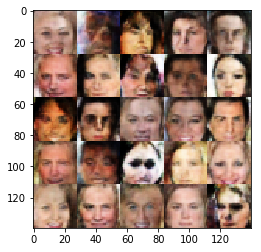

Epoch 4/10... Discriminator Loss: 1.0965... Generator Loss: 1.1229
Epoch 4/10... Discriminator Loss: 5.8879... Generator Loss: 2.4674
Epoch 4/10... Discriminator Loss: 0.9119... Generator Loss: 1.1237
Epoch 4/10... Discriminator Loss: 0.9223... Generator Loss: 1.1781
Epoch 4/10... Discriminator Loss: 1.0128... Generator Loss: 1.0142


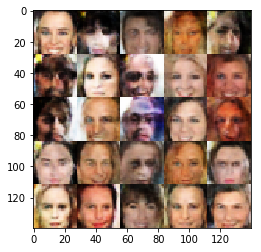

Epoch 4/10... Discriminator Loss: 0.8791... Generator Loss: 1.1447
Epoch 4/10... Discriminator Loss: 1.0012... Generator Loss: 1.1242
Epoch 4/10... Discriminator Loss: 0.9369... Generator Loss: 1.1389
Epoch 4/10... Discriminator Loss: 0.9866... Generator Loss: 1.1159
Epoch 4/10... Discriminator Loss: 5.3744... Generator Loss: 0.7674


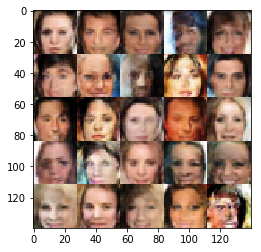

Epoch 4/10... Discriminator Loss: 0.9553... Generator Loss: 1.0437
Epoch 4/10... Discriminator Loss: 1.0465... Generator Loss: 1.1266
Epoch 4/10... Discriminator Loss: 1.0260... Generator Loss: 1.5967
Epoch 4/10... Discriminator Loss: 0.9949... Generator Loss: 1.0742
Epoch 4/10... Discriminator Loss: 0.9890... Generator Loss: 0.9998


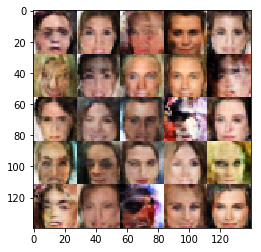

Epoch 4/10... Discriminator Loss: 0.8627... Generator Loss: 1.2198
Epoch 5/10... Discriminator Loss: 1.0048... Generator Loss: 1.0929
Epoch 5/10... Discriminator Loss: 1.0176... Generator Loss: 1.2064
Epoch 5/10... Discriminator Loss: 1.0206... Generator Loss: 0.9997
Epoch 5/10... Discriminator Loss: 3.9006... Generator Loss: 2.7132


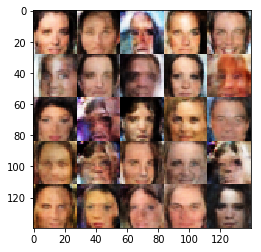

Epoch 5/10... Discriminator Loss: 1.0177... Generator Loss: 0.9620
Epoch 5/10... Discriminator Loss: 0.9338... Generator Loss: 1.0269
Epoch 5/10... Discriminator Loss: 0.8985... Generator Loss: 1.1183
Epoch 5/10... Discriminator Loss: 0.8996... Generator Loss: 1.0494
Epoch 5/10... Discriminator Loss: 1.0776... Generator Loss: 0.9430


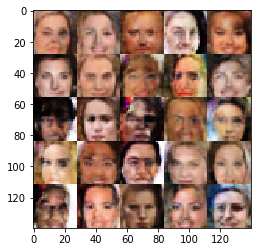

Epoch 5/10... Discriminator Loss: 0.9271... Generator Loss: 1.0680
Epoch 5/10... Discriminator Loss: 0.8990... Generator Loss: 1.0584
Epoch 5/10... Discriminator Loss: 0.9511... Generator Loss: 1.0459
Epoch 5/10... Discriminator Loss: 0.8532... Generator Loss: 1.2211
Epoch 5/10... Discriminator Loss: 1.0049... Generator Loss: 1.0511


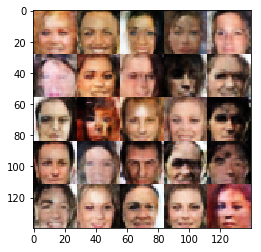

Epoch 5/10... Discriminator Loss: 0.9609... Generator Loss: 1.0627
Epoch 5/10... Discriminator Loss: 1.0236... Generator Loss: 1.0705
Epoch 5/10... Discriminator Loss: 0.9821... Generator Loss: 1.0129
Epoch 5/10... Discriminator Loss: 0.9176... Generator Loss: 1.2414
Epoch 5/10... Discriminator Loss: 0.8420... Generator Loss: 1.1244


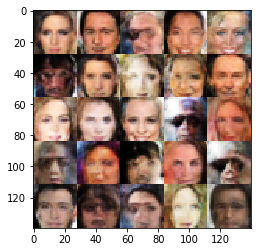

Epoch 5/10... Discriminator Loss: 0.8814... Generator Loss: 1.3937
Epoch 5/10... Discriminator Loss: 0.7872... Generator Loss: 1.3897
Epoch 5/10... Discriminator Loss: 0.9732... Generator Loss: 0.9908
Epoch 5/10... Discriminator Loss: 0.9740... Generator Loss: 0.9873
Epoch 5/10... Discriminator Loss: 0.9793... Generator Loss: 1.1284


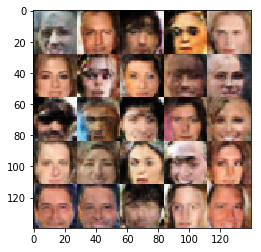

Epoch 5/10... Discriminator Loss: 1.1192... Generator Loss: 0.9715
Epoch 5/10... Discriminator Loss: 0.9493... Generator Loss: 1.0495
Epoch 5/10... Discriminator Loss: 0.9313... Generator Loss: 0.9887
Epoch 5/10... Discriminator Loss: 0.8509... Generator Loss: 1.1713
Epoch 5/10... Discriminator Loss: 0.9407... Generator Loss: 1.2790


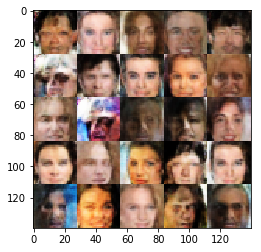

Epoch 5/10... Discriminator Loss: 0.7753... Generator Loss: 1.4923
Epoch 5/10... Discriminator Loss: 1.0459... Generator Loss: 0.9431
Epoch 5/10... Discriminator Loss: 2.0663... Generator Loss: 1.8750
Epoch 6/10... Discriminator Loss: 0.9778... Generator Loss: 0.9861
Epoch 6/10... Discriminator Loss: 0.9485... Generator Loss: 1.0154


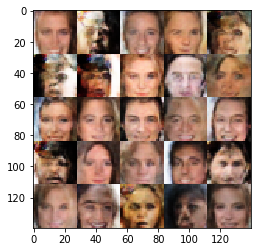

Epoch 6/10... Discriminator Loss: 0.9500... Generator Loss: 0.9859
Epoch 6/10... Discriminator Loss: 0.9815... Generator Loss: 1.1124
Epoch 6/10... Discriminator Loss: 1.0115... Generator Loss: 1.2937
Epoch 6/10... Discriminator Loss: 0.9809... Generator Loss: 1.0668
Epoch 6/10... Discriminator Loss: 0.9494... Generator Loss: 1.0796


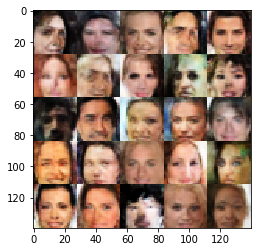

Epoch 6/10... Discriminator Loss: 1.0201... Generator Loss: 1.0203
Epoch 6/10... Discriminator Loss: 0.8371... Generator Loss: 1.2713
Epoch 6/10... Discriminator Loss: 0.9703... Generator Loss: 1.0979
Epoch 6/10... Discriminator Loss: 1.0134... Generator Loss: 0.9828
Epoch 6/10... Discriminator Loss: 5.9740... Generator Loss: 1.6380


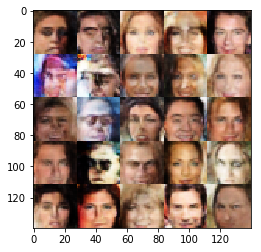

Epoch 6/10... Discriminator Loss: 0.9360... Generator Loss: 1.3319
Epoch 6/10... Discriminator Loss: 0.9762... Generator Loss: 1.0005
Epoch 6/10... Discriminator Loss: 0.9966... Generator Loss: 1.0461
Epoch 6/10... Discriminator Loss: 1.0251... Generator Loss: 1.2079
Epoch 6/10... Discriminator Loss: 0.9753... Generator Loss: 1.0811


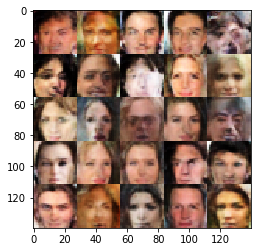

Epoch 6/10... Discriminator Loss: 0.9530... Generator Loss: 0.9679
Epoch 6/10... Discriminator Loss: 0.8787... Generator Loss: 1.1416
Epoch 6/10... Discriminator Loss: 0.9794... Generator Loss: 0.8745
Epoch 6/10... Discriminator Loss: 0.9103... Generator Loss: 1.1473
Epoch 6/10... Discriminator Loss: 0.8448... Generator Loss: 1.2994


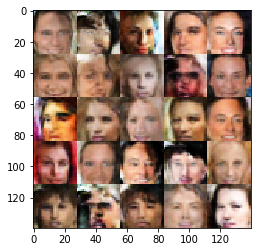

Epoch 6/10... Discriminator Loss: 0.9629... Generator Loss: 0.9610
Epoch 6/10... Discriminator Loss: 0.9131... Generator Loss: 1.1192
Epoch 6/10... Discriminator Loss: 0.9873... Generator Loss: 0.9968
Epoch 6/10... Discriminator Loss: 1.1581... Generator Loss: 0.8870
Epoch 6/10... Discriminator Loss: 1.0450... Generator Loss: 1.1725


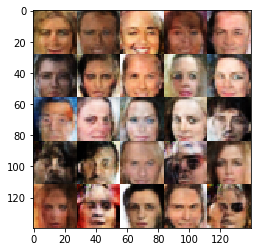

Epoch 6/10... Discriminator Loss: 0.9860... Generator Loss: 1.1200
Epoch 6/10... Discriminator Loss: 1.2254... Generator Loss: 0.9663
Epoch 6/10... Discriminator Loss: 0.9723... Generator Loss: 1.0924
Epoch 6/10... Discriminator Loss: 0.9613... Generator Loss: 1.0178
Epoch 7/10... Discriminator Loss: 0.9252... Generator Loss: 0.9745


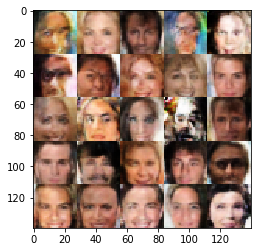

Epoch 7/10... Discriminator Loss: 0.9746... Generator Loss: 1.0176
Epoch 7/10... Discriminator Loss: 1.0480... Generator Loss: 1.0289
Epoch 7/10... Discriminator Loss: 0.9991... Generator Loss: 0.9865
Epoch 7/10... Discriminator Loss: 0.9723... Generator Loss: 1.0177
Epoch 7/10... Discriminator Loss: 1.0741... Generator Loss: 1.0473


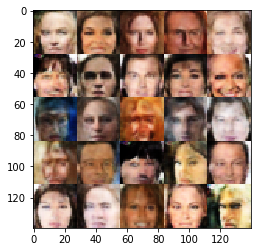

Epoch 7/10... Discriminator Loss: 1.0648... Generator Loss: 0.8896
Epoch 7/10... Discriminator Loss: 1.0478... Generator Loss: 1.2451
Epoch 7/10... Discriminator Loss: 1.1664... Generator Loss: 1.0294
Epoch 7/10... Discriminator Loss: 1.0299... Generator Loss: 0.9792
Epoch 7/10... Discriminator Loss: 0.9693... Generator Loss: 0.9440


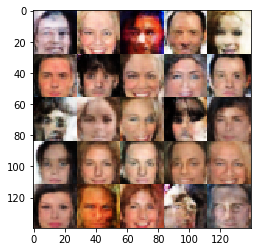

Epoch 7/10... Discriminator Loss: 0.9862... Generator Loss: 1.0080
Epoch 7/10... Discriminator Loss: 0.9842... Generator Loss: 0.9863
Epoch 7/10... Discriminator Loss: 0.9560... Generator Loss: 1.2212
Epoch 7/10... Discriminator Loss: 0.9168... Generator Loss: 0.9778
Epoch 7/10... Discriminator Loss: 0.9469... Generator Loss: 1.0806


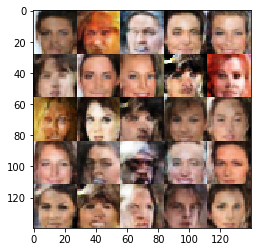

Epoch 7/10... Discriminator Loss: 1.1010... Generator Loss: 0.9110
Epoch 7/10... Discriminator Loss: 0.9905... Generator Loss: 1.1224
Epoch 7/10... Discriminator Loss: 1.0966... Generator Loss: 1.0376
Epoch 7/10... Discriminator Loss: 1.0849... Generator Loss: 0.9834
Epoch 7/10... Discriminator Loss: 1.0103... Generator Loss: 0.9739


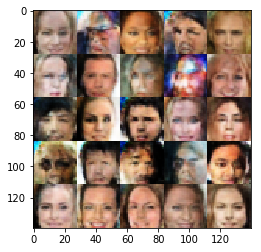

Epoch 7/10... Discriminator Loss: 0.9180... Generator Loss: 1.0573
Epoch 7/10... Discriminator Loss: 1.0408... Generator Loss: 0.9059
Epoch 7/10... Discriminator Loss: 1.0436... Generator Loss: 1.1034
Epoch 7/10... Discriminator Loss: 0.8893... Generator Loss: 1.2105
Epoch 7/10... Discriminator Loss: 1.0022... Generator Loss: 1.0285


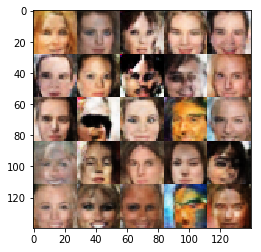

Epoch 7/10... Discriminator Loss: 1.0411... Generator Loss: 0.9586
Epoch 7/10... Discriminator Loss: 1.0220... Generator Loss: 1.0378
Epoch 7/10... Discriminator Loss: 0.9407... Generator Loss: 1.1306
Epoch 7/10... Discriminator Loss: 1.1378... Generator Loss: 0.8359
Epoch 7/10... Discriminator Loss: 1.0078... Generator Loss: 0.9491


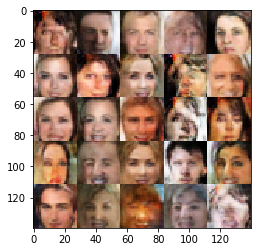

Epoch 7/10... Discriminator Loss: 1.0120... Generator Loss: 1.0408
Epoch 8/10... Discriminator Loss: 1.0794... Generator Loss: 1.2995
Epoch 8/10... Discriminator Loss: 0.9334... Generator Loss: 1.0871
Epoch 8/10... Discriminator Loss: 0.9776... Generator Loss: 1.0743
Epoch 8/10... Discriminator Loss: 0.9525... Generator Loss: 1.0885


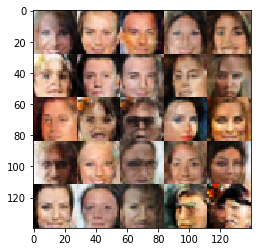

Epoch 8/10... Discriminator Loss: 1.0387... Generator Loss: 0.9634
Epoch 8/10... Discriminator Loss: 0.9381... Generator Loss: 1.1641
Epoch 8/10... Discriminator Loss: 1.0060... Generator Loss: 1.0243
Epoch 8/10... Discriminator Loss: 0.9423... Generator Loss: 1.2276
Epoch 8/10... Discriminator Loss: 1.0844... Generator Loss: 0.8196


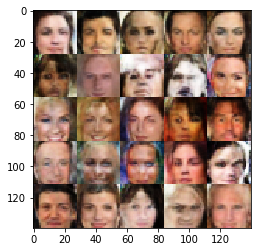

Epoch 8/10... Discriminator Loss: 1.0124... Generator Loss: 1.0913
Epoch 8/10... Discriminator Loss: 1.0505... Generator Loss: 1.0005
Epoch 8/10... Discriminator Loss: 3.0644... Generator Loss: 0.2948
Epoch 8/10... Discriminator Loss: 0.9691... Generator Loss: 1.1209
Epoch 8/10... Discriminator Loss: 1.0910... Generator Loss: 1.1124


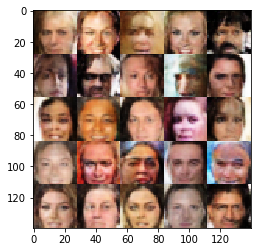

Epoch 8/10... Discriminator Loss: 1.0353... Generator Loss: 1.0333
Epoch 8/10... Discriminator Loss: 1.0212... Generator Loss: 1.0744
Epoch 8/10... Discriminator Loss: 1.0723... Generator Loss: 0.8976
Epoch 8/10... Discriminator Loss: 1.0073... Generator Loss: 1.0142
Epoch 8/10... Discriminator Loss: 0.9814... Generator Loss: 1.0136


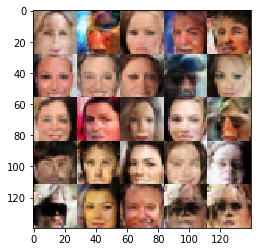

Epoch 8/10... Discriminator Loss: 1.0262... Generator Loss: 0.9728
Epoch 8/10... Discriminator Loss: 0.9137... Generator Loss: 1.1582
Epoch 8/10... Discriminator Loss: 1.0967... Generator Loss: 0.8608
Epoch 8/10... Discriminator Loss: 0.8713... Generator Loss: 1.2113
Epoch 8/10... Discriminator Loss: 1.0160... Generator Loss: 0.9631


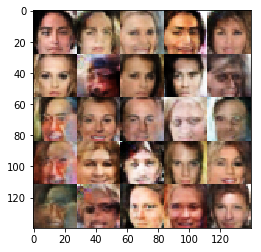

Epoch 8/10... Discriminator Loss: 1.2096... Generator Loss: 1.2414
Epoch 8/10... Discriminator Loss: 1.0292... Generator Loss: 0.9144
Epoch 8/10... Discriminator Loss: 0.9586... Generator Loss: 1.0499
Epoch 8/10... Discriminator Loss: 0.9784... Generator Loss: 1.1451
Epoch 8/10... Discriminator Loss: 1.0334... Generator Loss: 0.8594


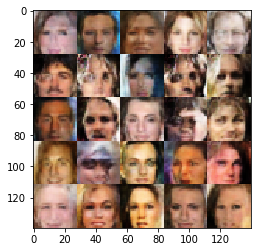

Epoch 8/10... Discriminator Loss: 1.0176... Generator Loss: 1.1110
Epoch 8/10... Discriminator Loss: 1.0063... Generator Loss: 1.1229
Epoch 8/10... Discriminator Loss: 0.9101... Generator Loss: 1.1778
Epoch 9/10... Discriminator Loss: 0.9928... Generator Loss: 1.1897
Epoch 9/10... Discriminator Loss: 1.0263... Generator Loss: 0.9711


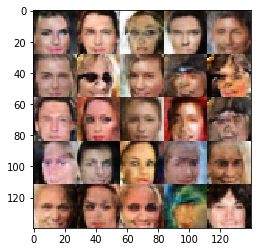

Epoch 9/10... Discriminator Loss: 1.0814... Generator Loss: 1.0163
Epoch 9/10... Discriminator Loss: 1.0042... Generator Loss: 1.0265
Epoch 9/10... Discriminator Loss: 0.9470... Generator Loss: 1.0604
Epoch 9/10... Discriminator Loss: 1.0356... Generator Loss: 0.9912
Epoch 9/10... Discriminator Loss: 0.9591... Generator Loss: 0.9597


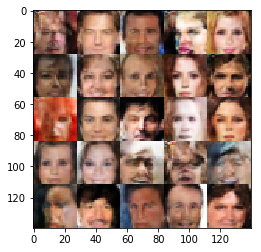

Epoch 9/10... Discriminator Loss: 1.0316... Generator Loss: 1.0853
Epoch 9/10... Discriminator Loss: 0.9690... Generator Loss: 0.9977
Epoch 9/10... Discriminator Loss: 1.0275... Generator Loss: 0.8850
Epoch 9/10... Discriminator Loss: 1.0701... Generator Loss: 0.8787
Epoch 9/10... Discriminator Loss: 1.0339... Generator Loss: 1.1073


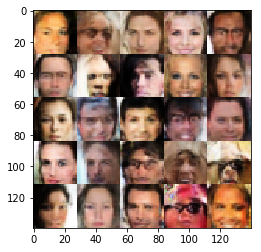

Epoch 9/10... Discriminator Loss: 1.0541... Generator Loss: 1.0595
Epoch 9/10... Discriminator Loss: 1.0544... Generator Loss: 1.0900
Epoch 9/10... Discriminator Loss: 1.0023... Generator Loss: 1.0802
Epoch 9/10... Discriminator Loss: 1.0554... Generator Loss: 1.0676
Epoch 9/10... Discriminator Loss: 1.0118... Generator Loss: 0.9989


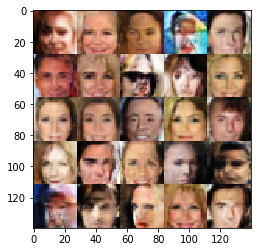

Epoch 9/10... Discriminator Loss: 1.0384... Generator Loss: 1.0484
Epoch 9/10... Discriminator Loss: 1.0526... Generator Loss: 1.0942
Epoch 9/10... Discriminator Loss: 0.9625... Generator Loss: 1.0788
Epoch 9/10... Discriminator Loss: 1.9710... Generator Loss: 1.3179
Epoch 9/10... Discriminator Loss: 1.1094... Generator Loss: 0.8688


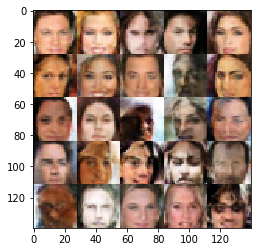

Epoch 9/10... Discriminator Loss: 1.0205... Generator Loss: 1.0727
Epoch 9/10... Discriminator Loss: 1.0706... Generator Loss: 0.9361
Epoch 9/10... Discriminator Loss: 0.9277... Generator Loss: 1.0360
Epoch 9/10... Discriminator Loss: 0.9808... Generator Loss: 0.9592
Epoch 9/10... Discriminator Loss: 1.0046... Generator Loss: 1.0346


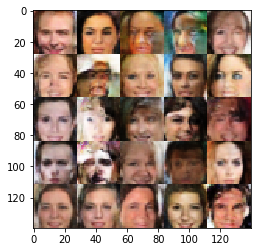

Epoch 9/10... Discriminator Loss: 0.9546... Generator Loss: 1.0198
Epoch 9/10... Discriminator Loss: 2.5840... Generator Loss: 1.1306
Epoch 9/10... Discriminator Loss: 1.0760... Generator Loss: 0.9154
Epoch 9/10... Discriminator Loss: 0.9891... Generator Loss: 1.0336
Epoch 10/10... Discriminator Loss: 1.0428... Generator Loss: 0.9336


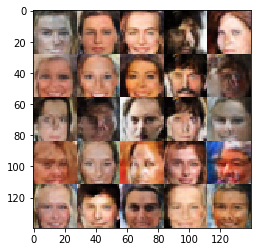

Epoch 10/10... Discriminator Loss: 1.0544... Generator Loss: 1.0064
Epoch 10/10... Discriminator Loss: 0.9542... Generator Loss: 1.1682
Epoch 10/10... Discriminator Loss: 0.9947... Generator Loss: 0.9645
Epoch 10/10... Discriminator Loss: 1.0159... Generator Loss: 0.8938
Epoch 10/10... Discriminator Loss: 0.9762... Generator Loss: 1.0296


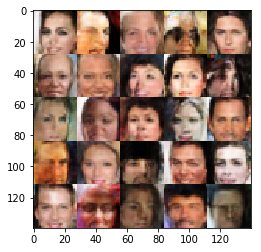

Epoch 10/10... Discriminator Loss: 0.9389... Generator Loss: 1.1362
Epoch 10/10... Discriminator Loss: 0.9502... Generator Loss: 1.0277
Epoch 10/10... Discriminator Loss: 6.8718... Generator Loss: 1.8270
Epoch 10/10... Discriminator Loss: 1.1156... Generator Loss: 0.9599
Epoch 10/10... Discriminator Loss: 1.0518... Generator Loss: 0.9224


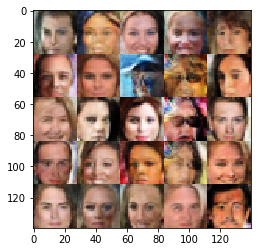

Epoch 10/10... Discriminator Loss: 0.9585... Generator Loss: 0.9758
Epoch 10/10... Discriminator Loss: 0.9736... Generator Loss: 0.9603
Epoch 10/10... Discriminator Loss: 0.9321... Generator Loss: 1.0152
Epoch 10/10... Discriminator Loss: 1.0129... Generator Loss: 0.9508
Epoch 10/10... Discriminator Loss: 1.0644... Generator Loss: 0.8936


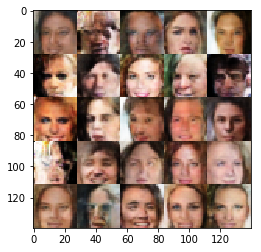

Epoch 10/10... Discriminator Loss: 1.0162... Generator Loss: 1.0253
Epoch 10/10... Discriminator Loss: 0.9833... Generator Loss: 1.0877
Epoch 10/10... Discriminator Loss: 0.9730... Generator Loss: 0.9799
Epoch 10/10... Discriminator Loss: 1.0351... Generator Loss: 0.8682


In [ ]:
batch_size = 64 #needs to be a factor of 4096
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5

print_every = 100
show_every = 500
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 10

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode, print_every, show_every)

__Note:__ I have also run this upto 50 epochs on AWS and that gave sharper and better outputs.  This is from the roughly 1 GB GPU that I have on my local machine, but I'm happy it already shows images in under 10 epochs ( even 1 epoch shows images that are recognizable as faces, but the quality does seem to improve with more epochs ).  

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.